# Imports 

### Iteration 3: NB_multinomial with word embeddings

In [ ]:

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from datasets import load_dataset
import time
from datetime import datetime
import json
import base64
import struct
import warnings
import torch
import os
warnings.filterwarnings('ignore')

In [30]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


In [3]:
# Global variables
EMBEDDING_COLUMN_NAMES = ["tfidf_embedding","bow_embedding","w2v_embedding", "roberta_embedding"]

In [3]:
# Function to decode the custom embedding format
def decode_embedding(encoded_str):
    """
    Decode the custom embedding format to a numeric vector.
    Example input: 'AQAAAAAAAABAAAAAAAAAAQAAAAAAAAEAAAAAAAAAAQA...'
    """
    try:
        # First try base64 decoding
        try:
            # Try standard base64
            decoded = base64.b64decode(encoded_str)
        except:
            # If that fails, try to pad the string and decode
            padding_needed = len(encoded_str) % 4
            if padding_needed:
                encoded_str += '=' * (4 - padding_needed)
            decoded = base64.b64decode(encoded_str)
        
        # Try to interpret as floats (8 bytes per float)
        if len(decoded) % 8 == 0:
            num_floats = len(decoded) // 8
            return np.array(struct.unpack(f'>{num_floats}d', decoded))
        
        # Try to interpret as floats (4 bytes per float)
        if len(decoded) % 4 == 0:
            num_floats = len(decoded) // 4
            return np.array(struct.unpack(f'>{num_floats}f', decoded))
            
        # If the above fail, try to interpret as a sequence of bytes
        return np.frombuffer(decoded, dtype=np.uint8)
    
    except Exception as e:
        print(f"Error decoding embedding: {e}")
        # As a fallback, convert each character to its ASCII value
        return np.array([ord(c) for c in encoded_str])

### Load Training Dataset

Load the training dataset with CBOW-W2V embeddings

In [4]:
dataset = load_dataset("Paulozs/WELFake_embeddings")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


### Split Dataset

In [12]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
display(df)

,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


# TF-IDF Embedding

In [13]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df["tfidf_embedding"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

6312     [0.2913193475178382, -0.25964890109450217, -0....
1575     [0.3458007493067191, 0.1488610801652892, -0.09...
34150    [0.22471385300739916, -0.21535486255894393, 0....
20440    [0.21976064678214624, -0.04813982501158199, -0...
49987    [0.36752246000471256, -0.17607963257083178, -0...
                               ...                        
12895    [0.20483901494858434, -0.04508991069278617, 0....
60960    [0.296419404864837, -0.04091803082821383, 0.07...
6012     [0.10656974408814512, -0.02633602960051711, 0....
6558     [0.2775299676755072, -0.1994376435245847, 0.12...
56267    [0.2667877512487862, 0.06728728052018784, 0.26...
Name: tfidf_embedding, Length: 50073, dtype: object 6312     1
1575     1
34150    0
20440    0
49987    0
        ..
12895    1
60960    1
6012     1
6558     0
56267    1
Name: label, Length: 50073, dtype: int64


## Scale the features

In [24]:
# fix the shape of the data

x_train_fixed = np.stack(x_train)  
x_test_fixed = np.stack(x_test)
# Check the shape of the data
print(x_train_fixed.shape)  
print(x_test_fixed.shape)

(50073, 300)
(12519, 300)


In [25]:
print("\nScaling features...")
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_fixed)

x_test_scaled = scaler.transform(x_test_fixed)
print("Features scaled successfully")
# remove Nan values from the dataset
x_train_scaled = np.nan_to_num(x_train_scaled, nan=0.0)
x_test_scaled = np.nan_to_num(x_test_scaled, nan=0.0)


Scaling features...
Features scaled successfully


In [18]:
nb = MultinomialNB()

## Hyper Parameter Tuning

In [27]:
# RandomizedSearchCV - includes cross-validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for MultinomialNB
param_dist = {'alpha': uniform(0.001, 10.0)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(nb, 
                                 param_distributions=param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train_scaled, y_train)


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022558BC7370>},
                   random_state=45)

In [28]:
# Create a variable for the best model
tfidf_nb_multinomial = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'alpha': np.float64(9.891115134756001)}


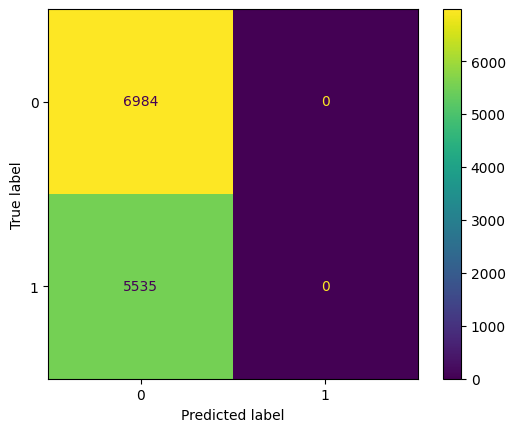

In [32]:
# Generate predictions with the best model
y_pred = tfidf_nb_multinomial.predict(x_test_fixed)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5578720345075485
Precision: 0.0
Recall: 0.0


## Hyper Parameter Optimization

In [ ]:
print("\nPerforming hyperparameter optimization...")
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

print("Fitting grid search...")
grid_search.fit(x_train_scaled, y_train)

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_
print(f"Best alpha parameter: {best_alpha}")
print(f"Best cross-validation score: {best_score:.4f}")


Performing hyperparameter optimization...
Fitting grid search...
Best alpha parameter: 0.001
Best cross-validation score: 0.5558


## K-fold cross validation
Use the best parameter

In [ ]:
print("\nPerforming k-fold cross-validation with best alpha...")
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
nb_cv = MultinomialNB(alpha=best_alpha)
cv_scores = cross_val_score(nb_cv, x_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")


Performing k-fold cross-validation with best alpha...
CV Accuracy: 0.5558 ± 0.0011
Individual fold scores: [0.5542775  0.55571531 0.55767695 0.55591948 0.55552005]


## Train final model with best parameters

In [ ]:
print("\nTraining the final model...")
nb_final = MultinomialNB(alpha=best_alpha)
nb_final.fit(x_train_scaled, y_train)
print("Model training complete")


Training the final model...
Model training complete


## Evaluate on test set

In [ ]:
print("\nEvaluating model performance on test set...")
y_pred = nb_final.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
class_report_dict = classification_report(y_test, y_pred, output_dict=True)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print("Classification Report:")
print(class_report)


Evaluating model performance on test set...
Test Accuracy: 0.5259
Confusion Matrix:
[[2956 1612]
 [1659  673]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      4568
           1       0.29      0.29      0.29      2332

    accuracy                           0.53      6900
   macro avg       0.47      0.47      0.47      6900
weighted avg       0.52      0.53      0.52      6900



## Feature importance analysis

In [12]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      4568
           1       0.29      0.29      0.29      2332

    accuracy                           0.53      6900
   macro avg       0.47      0.47      0.47      6900
weighted avg       0.52      0.53      0.52      6900



In [13]:
print("\nAnalyzing feature importance...")
try:
    feature_importance = nb_final.feature_log_prob_[1] - nb_final.feature_log_prob_[0]
    top_features_idx = np.argsort(feature_importance)[-10:]  # Get indices of top 10 most important features
    
    print("Top 10 most important features (by difference in log probability):")
    for i, idx in enumerate(top_features_idx[::-1], 1):
        print(f"{i}. Feature {idx}: {feature_importance[idx]:.4f}")
except Exception as e:
    print(f"Could not analyze feature importance: {e}")

# 9. Save results
print("\nSaving results...")
results = {
    "model_name": "MultinomialNB with CBOW-W2V (custom encoding)",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "best_alpha": float(best_alpha),
    "best_cv_score": float(best_score),
    "k_fold_cv_scores": {
        "mean": float(cv_scores.mean()),
        "std": float(cv_scores.std()),
        "individual_folds": cv_scores.tolist()
    },
    "test_metrics": {
        "accuracy": float(accuracy),
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": class_report_dict
    },
}
# Ensure the results directory exists
if not os.path.exists('model_results'):
    os.makedirs('model_results')
    
results_filename = f"model_results/nb_multinomial_cbow_w2v_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
try:
    with open(results_filename, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_filename}")
except Exception as e:
    print(f"Could not save results to file: {e}")

print("\nImplementation complete!")


Analyzing feature importance...
Top 10 most important features (by difference in log probability):
1. Feature 2: 0.1764
2. Feature 4: 0.1077
3. Feature 8: 0.0712
4. Feature 3: 0.0672
5. Feature 19: 0.0576
6. Feature 0: 0.0449
7. Feature 6: 0.0363
8. Feature 47: 0.0302
9. Feature 36: 0.0297
10. Feature 28: 0.0235

Saving results...
Results saved to model_results/nb_multinomial_cbow_w2v_results_20250421_180041.json

Implementation complete!
